# Idealized Case 2: Two crossing Blobs

In this tutorial, the different methods of the linking process are explained using the example of two crossing features, including an in depth explanaition on how the linking is done for complicated cases. The following chapters are covered:

1. [Data Generation](#1.-Data-Generation)
2. [Influence of Tracking Method](#2.-Influence-of-the-Tracking-Method)
3. [Tracking Algorithm](#3.-Tracking-Algorithm)

## 1. Data Generation

We start by importing the usual libraries and adjusting some settings:

In [180]:
import tobac
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import seaborn as sns

sns.set_context("talk")
%matplotlib inline

We will need to generate our own dataset for this tutorial. For this reason we define some bounds for our system and create a mesh from them:

In [217]:
x_min, y_min, x_max, y_max, = (
    0,
    0,
    1e5,
    1e5,
)
t_min, t_max = 0, 181

N_x = 100
N_y = 100
N_t = 19

x = np.linspace(x_min, x_max, N_x)
y = np.linspace(y_min, y_max, N_y)
t = np.linspace(t_min, t_max, N_t+1)

tt, yy, xx = np.meshgrid(t, y, x, indexing="ij")

The dataset is created by using two functions. The first creates a wandering gausian blob as `numpy`-Array on our grid, and the second transform it into an `xarray`-DataArry with an arbitary `datetime`.

In [218]:
def create_wandering_blob(
    x_0, y_0, v_x, v_y, sigma=1e7, t_create=t_min, t_vanish=t_max
):

    exponent = (xx - x_0 - v_x * (tt - t_create)) ** 2 + (
        yy - y_0 - v_y * (tt - t_create)
    ) ** 2
    
    feature_alive = np.logical_and(tt >= t_create, tt <= t_vanish)
    blob = np.where(feature_alive, np.exp(-exponent / sigma), 0)

    return blob


def create_xarray(array):

    t_0 = np.datetime64("2022-04-01T00:00")
    t_delta = np.timedelta64(int(t_max/N_t), "s")
    time = np.array([t_0 + i * t_delta for i in range(len(array))])

    coords = {"time": time, "projection_x_coordinate": x, "projection_y_coordinate": y}

    attributes = {"units": ("m s-1")}

    data = xr.DataArray(data=array, coords=coords, attrs=attributes)
    return data

We use the first function to create two blobs that cross each other. To keep them detectable as seperate features in the dataset we don't wanna just add them together. Instead we are going to use the highest value of each pixel by using a boolean mask and the resulting field is transformed into the `xarray` format.

In [219]:
blob_1 = create_wandering_blob(0, 0, 0.5e3, 0.5e3)
blob_2 = create_wandering_blob(1e5, 0, -0.5e3, 0.5e3)
blob_mask = blob_1 > blob_2
blob = np.where(blob_mask, blob_1, blob_2)

data = create_xarray(blob)

Let's check if we achived what we wanted by plotting the result:

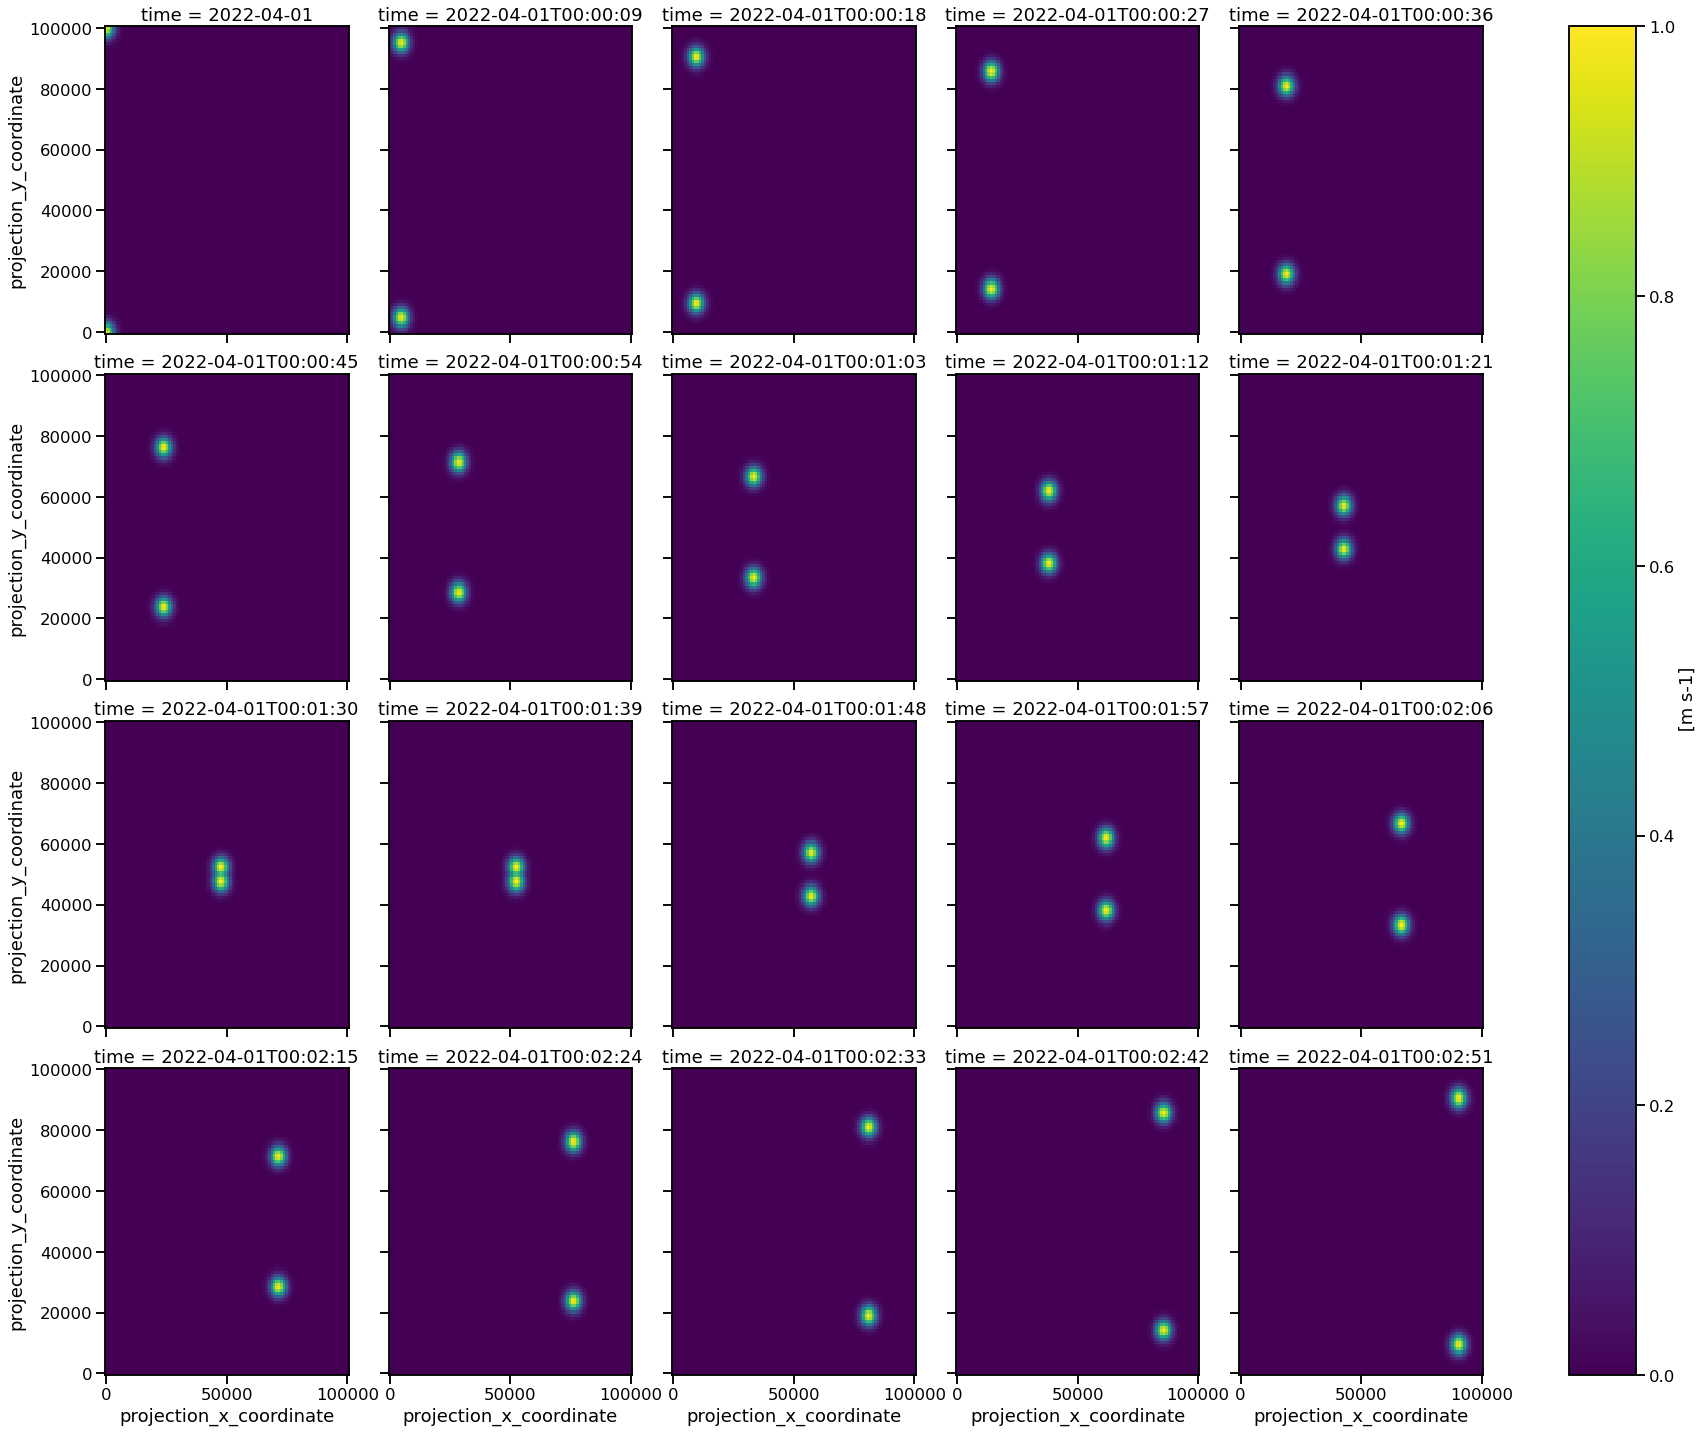

In [220]:
data.plot(
    cmap="viridis",
    col="time",
    col_wrap=5,
    x="projection_x_coordinate",
    y="projection_y_coordinate",
    size=5,
)

Looks good! We have two features crossing each other, and they are clearly seperable in every frame.

## 2. Influence of the Tracking Method

Before we can perform the tracking we need to detect the features with the usual function. The grid spacing is deduced from the data generation and the threshold is selected according to the colorbar.

In [221]:
%%capture
dxy, dt = tobac.utils.get_spacings(data, grid_spacing=x_max / N_x)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(
    data, dxy, threshold=0.9
)

Now the tracking can be performed. We will create two outputs, one with `method` = 'random', and the other one with `method` = 'predict'.

In [222]:
%matplotlib inline
d_max = 20000

track_1 = tobac.themes.tobac_v1.linking_trackpy(
    features, data, dt, dxy, d_max=d_max, method_linking="random"
)

track_2 = tobac.themes.tobac_v1.linking_trackpy(
    features, data, dt, dxy, d_max=d_max, method_linking="predict"
)

Frame 19: 2 trajectories present.


Let's have a look at the results:

Text(0.5, 1.0, 'predict')

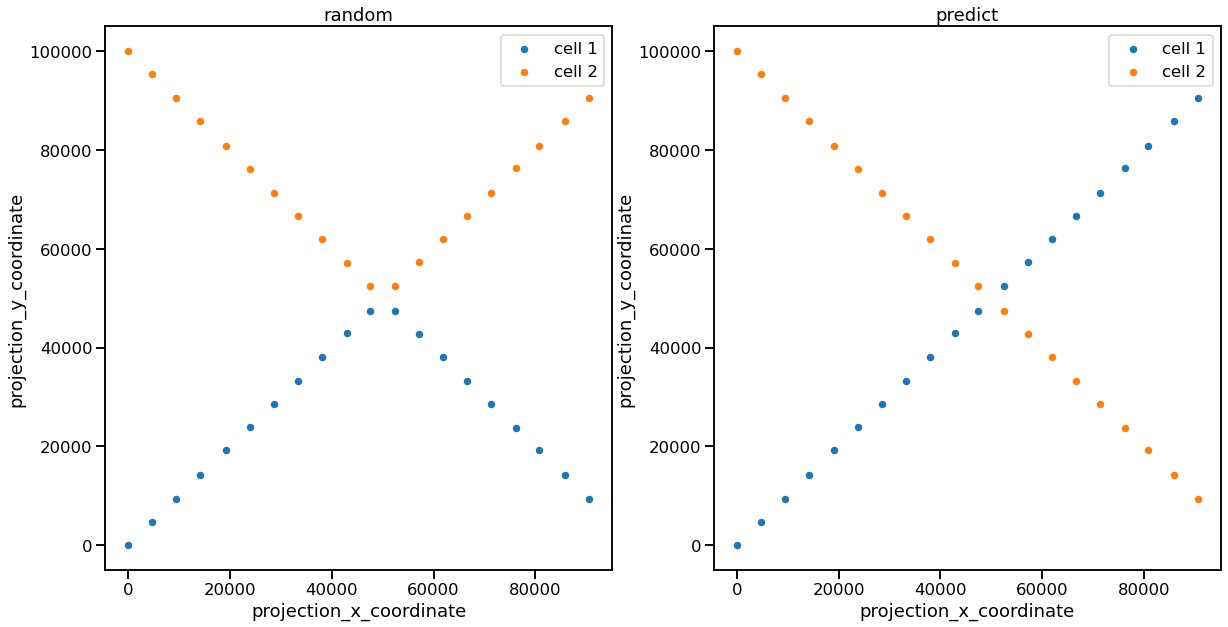

In [223]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

for i, cell_track in track_1.groupby("cell"):
    cell_track.plot.scatter(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax1,
        marker="o",
        label="cell {0}".format(int(i)),
    )
ax1.legend()
ax1.set_title("random")

for i, cell_track in track_2.groupby("cell"):

    cell_track.plot.scatter(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax2,
        marker="o",
        label="cell {0}".format(int(i)),
    )
ax2.legend()
ax2.set_title("predict")

As you can see, there is a clear difference. While in the first link output the feature positions in the top half of the graph are linked into one cell, in the second output the path of the cell follows the actual path of the Gaussian blobs we created. While intuitively this makes some sense based on the names of the methods, we will now take a more detailed look at how this works.

## Analysis

In [224]:
track_1 = tobac.analysis.calculate_velocity(track_1)
track_2 = tobac.analysis.calculate_velocity(track_2)

v1 = track_1.where(track_1['cell']==1).dropna().v.values
v2 = track_2.where(track_1['cell']==1).dropna().v.values

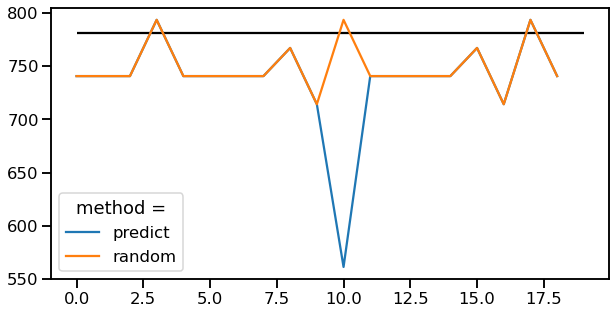

In [229]:
plt.figure(figsize = (10, 5))
plt.plot(v1, label = 'predict')
plt.plot(v2, label = 'random')
plt.hlines([np.sqrt(x_max**2+y_max**2)/t_max], xmin=0, xmax=len(v1), color = 'black')
plt.legend(title='method =')

## 3. Tracking Algorithm

The tracking uses the Crocker-Grier-Algorithm, originally introduced in this [paper](https://crocker.seas.upenn.edu/CrockerGrier1996b.pdf). Of course the most interesting decision in our dataset regarding the linking happens at the point of the crossing. That's why we start with a quick look at those frames:

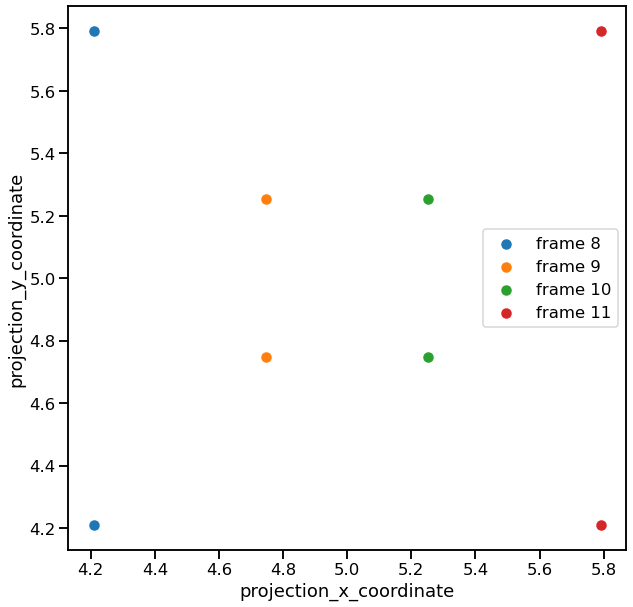

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

for frame in [8, 9, 10, 11]:

    features.where(features["frame"] == frame).plot.scatter(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax,
        label="frame {}".format(frame),
    )
plt.legend()
plt.show()

How to 'correctly' connnect the features from frame 8 and 9 is ovious, the same applies for frame 10 and 11. The remaining question is how the decision is made for frame 9 and 10.

### Search Radius 

The algorithm works by looking at every possible combination of features from the current frame and the next frame. Since this introduces a high computational complexity a first step is to ommit some of the features outside a search radius. To visualize this, we use need the positions of the features of frame 8, 9 and 10:

In [12]:
position_0 = (
    features.where(features["frame"] == 8).dropna(dim="index")["hdim_1"][0],
    features.where(features["frame"] == 8).dropna(dim="index")["hdim_2"][0],
)

position_1 = (
    features.where(features["frame"] == 8).dropna(dim="index")["hdim_1"][1],
    features.where(features["frame"] == 8).dropna(dim="index")["hdim_2"][1],
    
)
position_2 = (
    features.where(features["frame"] == 9).dropna(dim="index")["hdim_1"][0],
    features.where(features["frame"] == 9).dropna(dim="index")["hdim_2"][0],
)

position_3 = (
    features.where(features["frame"] == 9).dropna(dim="index")["hdim_1"][1],
    features.where(features["frame"] == 9).dropna(dim="index")["hdim_2"][1],
)

position_4 = (
    features.where(features["frame"] == 10).dropna(dim="index")["hdim_1"][0],
    features.where(features["frame"] == 10).dropna(dim="index")["hdim_2"][0],
    
)
position_5 = (
    features.where(features["frame"] == 10).dropna(dim="index")["hdim_1"][1],
    features.where(features["frame"] == 10).dropna(dim="index")["hdim_2"][1],
)

If you look back to the linking t
hat we performed you can see that we used a variable `d_max` as input. The search radius is calcuated from this variable in the following way:

In [13]:
radius = int(d_max / dxy)

### Prediction

The difference of the two methods we used for the linking is where the center of the search radius is located. While the 'random'-`method` assumes an uncorrelated velocity of the tracked objects, the 'predict'-`method` uses the linked features from the last frame to predict a now position based on a simple interploation:

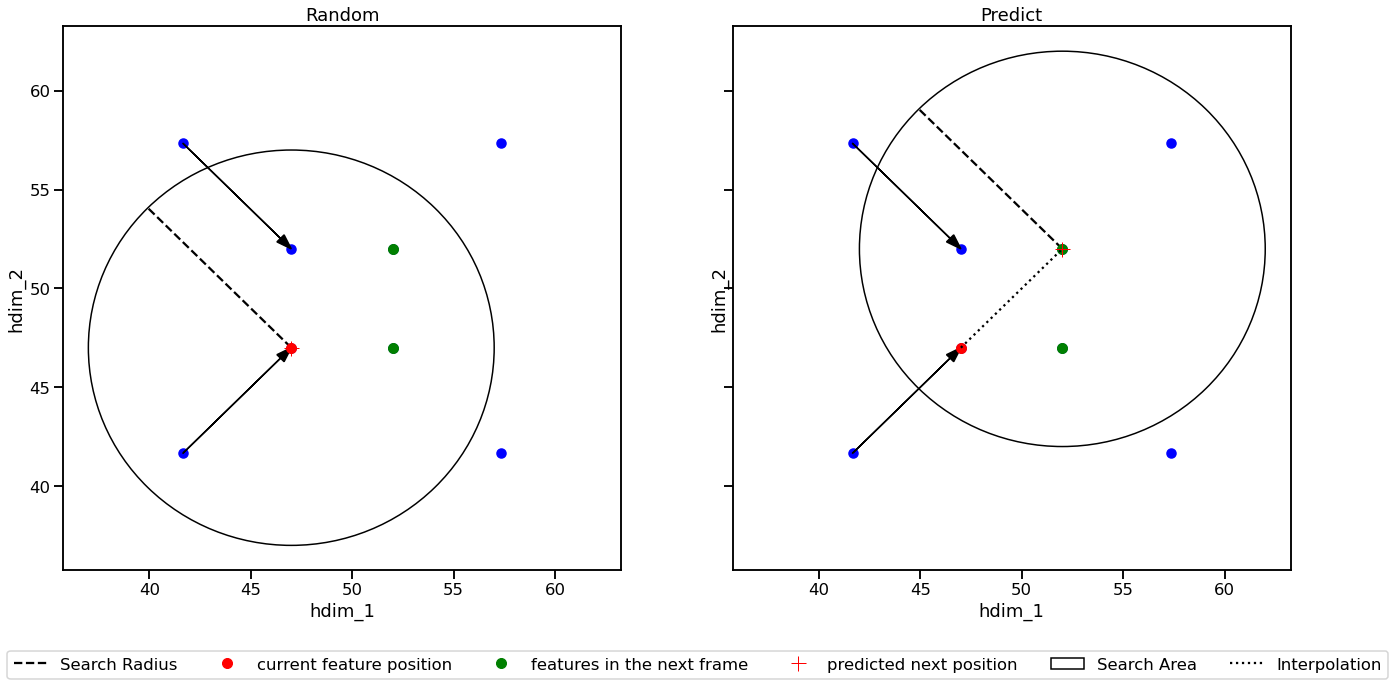

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(22, 10), sharex=True, sharey=True)

#All features scattered:
for frame in [8, 9, 10, 11]:

    features.where(features["frame"] == frame).plot.scatter(
        x="hdim_1", y="hdim_2", color="blue", ax=ax1
    )

    features.where(features["frame"] == frame).plot.scatter(
        x="hdim_1", y="hdim_2", color="blue", ax=ax2
    )

#Search radius of method = random    
ax1.plot([position_2[0], position_2[0]+ radius*np.cos(3*np.pi/4)], 
         [position_2[1], position_2[1]+ radius*np.sin(3*np.pi/4)], 
         "k--",
        label = 'Search Radius'
)

#Current feature
ax1.plot(
    position_2[0],
    position_2[1],
    marker="o",
    color="red",
    markersize=10,
    linestyle="",
    label="feature position",
)

ax1.plot(
    position_4[0],
    position_4[1],
    marker="o",
    color="green",
    markersize=10,
    linestyle="",
    label="features in the next frame",
)
ax1.plot(
    position_5[0],
    position_5[1],
    marker="o",
    color="green",
    markersize=10,
    linestyle="")

#Prediction of random is just current position 
ax1.plot(
    position_2[0],
    position_2[1],
    marker="+",
    color="red",
    markersize=15,
    linestyle="",
    label="predicted next position"
)

#Search area
circle_1 = plt.Circle(position_2, radius, fill=False, label="Search Area")
ax1.add_patch(circle_1)

#Vector from last feature
ax1.arrow(
    position_0[0],
    position_0[1],
    position_2[0] - position_0[0],
    position_2[1] - position_0[1],
    head_width=0.5,
    length_includes_head=True,
    color="black",
)

ax1.arrow(
    position_1[0],
    position_1[1],
    position_3[0] - position_1[0],
    position_3[1] - position_1[1],
    head_width=0.5,
    length_includes_head=True,
    color="black",
)

ax1.set_title("Random")

#Search radius of method = predict
ax2.plot([position_5[0], position_5[0]+ radius*np.cos(3*np.pi/4)], 
         [position_5[1], position_5[1]+ radius*np.sin(3*np.pi/4)], 
         "k--",
         label = 'Search Radius'
)

#Current feature
ax2.plot(
    position_2[0],
    position_2[1],
    marker="o",
    color="red",
    markersize=10,
    linestyle="",
    label="current feature position",
)

ax2.plot(
    position_4[0],
    position_4[1],
    marker="o",
    color="green",
    markersize=10,
    linestyle="",
    label="features in the next frame",
)
ax2.plot(
    position_5[0],
    position_5[1],
    marker="o",
    color="green",
    markersize=10,
    linestyle="",
)

#predicted position
ax2.plot(
    position_5[0],
    position_5[1],
    marker="+",
    color="red",
    markersize=15,
    linestyle="",
    label="predicted next position",
)

#Search area
circle_2 = plt.Circle(position_5, radius, fill=False, label="Search Area")
ax2.add_patch(circle_2)

#Vector from last feature
ax2.arrow(
    position_0[0],
    position_0[1],
    position_2[0] - position_0[0],
    position_2[1] - position_0[1],
    head_width=0.5,
    length_includes_head=True,
    color="black",
)

ax2.arrow(
    position_1[0],
    position_1[1],
    position_3[0] - position_1[0],
    position_3[1] - position_1[1],
    head_width=0.5,
    length_includes_head=True,
    color="black",
)

ax2.plot([position_2[0], position_5[0]], 
         [position_2[1], position_5[1]], 
         linestyle="dotted",
         color = 'black',
         label = 'Interpolation'
)

ax2.set_title("Predict")
ax2.legend(loc = (-1.3, -0.2), ncol= 6)

For both cased both of the features of frame 10 are within the search radius, but they differ in distance from the center of the search area, and that's whats decisive for the linking. The two options for linking look like this:

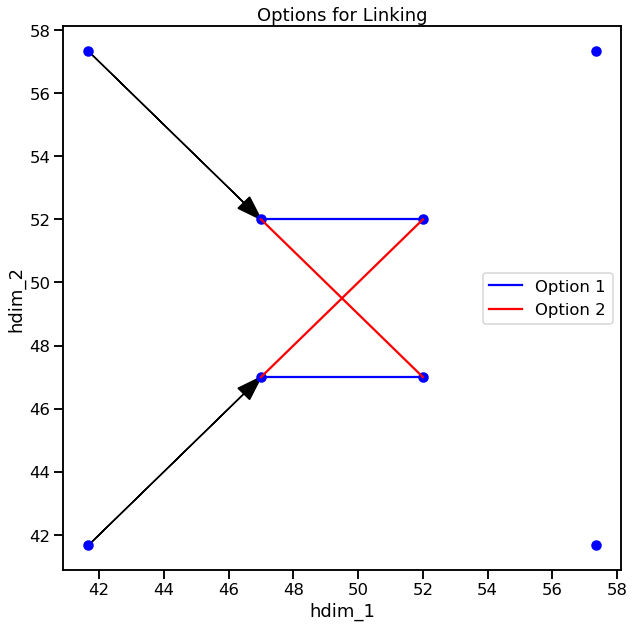

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.arrow(
    position_0[0],
    position_0[1],
    position_2[0] - position_0[0],
    position_2[1] - position_0[1],
    head_width=0.5,
    length_includes_head=True,
    color="black",
)

ax.arrow(
    position_1[0],
    position_1[1],
    position_3[0] - position_1[0],
    position_3[1] - position_1[1],
    head_width=0.5,
    length_includes_head=True,
    color="black",
)

ax.plot(
    [position_3[0], position_5[0]],
    [position_3[1], position_5[1]],
    color="blue",
    label="Option 1",
)
ax.plot([position_2[0], position_4[0]], 
        [position_2[1], position_4[1]], 
        color="blue"
       )

ax.plot(
    [position_2[0], position_5[0]],
    [position_2[1], position_5[1]],
    color="red",
    label="Option 2",
)
ax.plot([position_3[0], position_4[0]], 
        [position_3[1], position_4[1]], 
        color="red"
)

for frame in [8, 9, 10, 11]:

    features.where(features["frame"] == frame).plot.scatter(
        x="hdim_1", y="hdim_2", color="blue", ax=ax
    )
    
plt.title("Options for Linking")
plt.legend()

### Sum of the Distances

The set of distances from the predicted positions to the selected features of the next frame is denoted as $\{ \delta_i\}$. For every option (in our case the two vizualized above) the sum

$$\sum_{i=1}^N \delta_i^2$$

is calculated. The minimal value of this sum is the option that is used for linking. Let's look at these distances for both methods in our example:

Text(0.5, 0.98, 'Distances for')

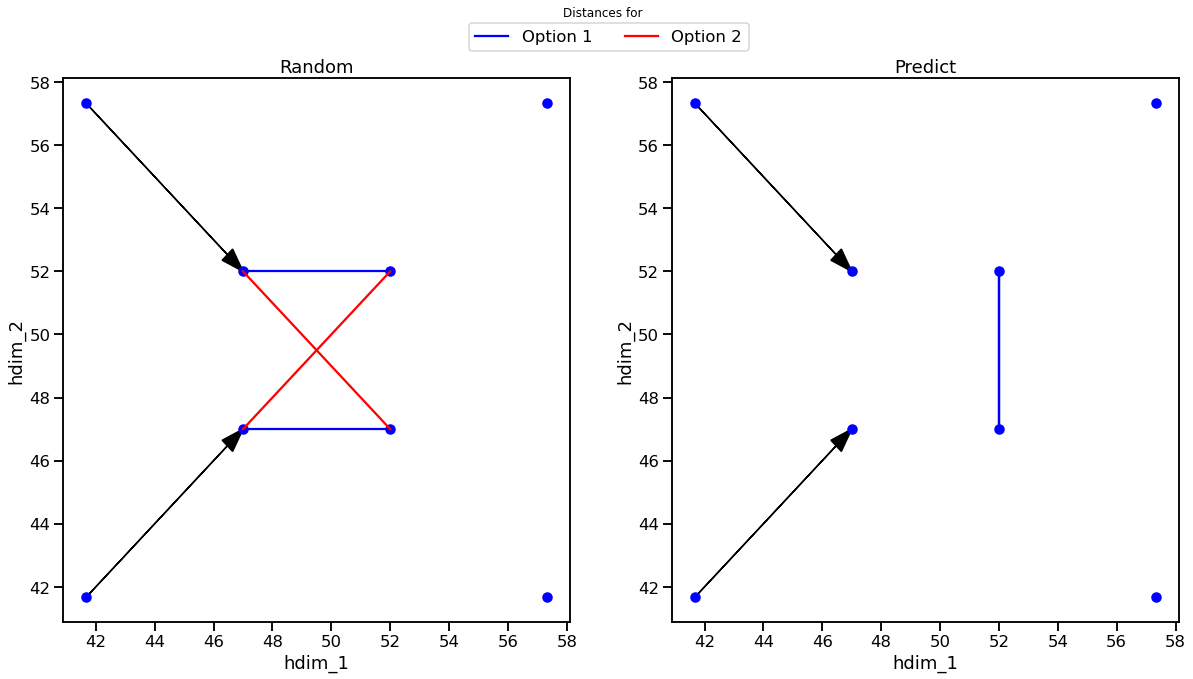

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20, 10))

ax1.arrow(
    position_0[0],
    position_0[1],
    position_2[0] - position_0[0],
    position_2[1] - position_0[1],
    head_width=0.5,
    length_includes_head=True,
    color="black",
)

ax1.arrow(
    position_1[0],
    position_1[1],
    position_3[0] - position_1[0],
    position_3[1] - position_1[1],
    head_width=0.5,
    length_includes_head=True,
    color="black",
)

ax1.plot(
    [position_3[0], position_5[0]],
    [position_3[1], position_5[1]],
    color="blue",
    label="Option 1",
)
ax1.plot([position_2[0], position_4[0]], 
        [position_2[1], position_4[1]], 
        color="blue"
       )

ax1.plot(
    [position_2[0], position_5[0]],
    [position_2[1], position_5[1]],
    color="red",
    label="Option 2",
)
ax1.plot([position_3[0], position_4[0]], 
        [position_3[1], position_4[1]], 
        color="red"
)

for frame in [8, 9, 10, 11]:

    features.where(features["frame"] == frame).plot.scatter(
        x="hdim_1", y="hdim_2", color="blue", ax=ax1
    )
    
ax2.arrow(
    position_0[0],
    position_0[1],
    position_2[0] - position_0[0],
    position_2[1] - position_0[1],
    head_width=0.5,
    length_includes_head=True,
    color="black",
)

ax2.arrow(
    position_1[0],
    position_1[1],
    position_3[0] - position_1[0],
    position_3[1] - position_1[1],
    head_width=0.5,
    length_includes_head=True,
    color="black",
)

ax2.plot(
    [position_4[0], position_5[0]],
    [position_4[1], position_5[1]],
    color="blue",
    label="Option 1",
)
ax2.plot([position_5[0], position_4[0]], 
        [position_5[1], position_4[1]], 
        color="blue"
       )

ax2.plot(
    [position_5[0], position_5[0]],
    [position_5[1], position_5[1]],
    color="red",
    label="Option 2",
)
ax2.plot([position_4[0], position_4[0]], 
        [position_4[1], position_4[1]], 
        color="red"
)

for frame in [8, 9, 10, 11]:

    features.where(features["frame"] == frame).plot.scatter(
        x="hdim_1", y="hdim_2", color="blue", ax=ax2
    )
ax1.set_title("Random")
ax2.set_title("Predict")
ax1.legend(loc = (0.8, 1.05), ncol= 2)

fig.suptitle('Distances for')

For `method = 'random'` it can be observed that the distances for option 2 are longer than those for option 1. For `method = 'random'` on the other hand there are no distances for option 2, because the interpolated particle positions exactly match the features, since we used a constant velocity in the data generation. This is how we end up with the different tracking behaviour of the two methods.